In [1]:
!pip install wfdb wget

     |████████████████████████████████| 122kB 12.8MB/s 
     |████████████████████████████████| 6.8MB 11.3MB/s 
     |████████████████████████████████| 163kB 59.7MB/s 
  Created wheel for wfdb: filename=wfdb-3.1.1-cp36-none-any.whl size=117828 sha256=7a156f7dc822176de62de655388f152c16fc3c83cf2ab05489d18e2254c56194
  Stored in directory: /root/.cache/pip/wheels/bc/d0/c1/90538d266ccba2d1076fbc9970192c7ea1a09c99df3e65c69b
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=27dc0b08d7989e6f5019496e31dbf02346cab1b10749dfbbaf7b4059ef1e8e53
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wfdb wget


In [2]:
!pip install -q kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
import os
import shutil

shutil.copy("/content/drive/My Drive/kaggle.json","./kaggle.json")

'./kaggle.json'

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [6]:
!kaggle datasets download -d bjoernjostein/georgia-12lead-ecg-challenge-database

 96% 463M/483M [00:06<00:00, 127MB/s]
100% 483M/483M [00:06<00:00, 72.5MB/s]


In [7]:
!kaggle datasets download -d bjoernjostein/st-petersburg-incart-12lead-arrhythmia-database

 96% 544M/564M [00:08<00:00, 47.2MB/s]
100% 564M/564M [00:08<00:00, 71.8MB/s]


In [8]:
!kaggle datasets download -d bjoernjostein/ptbxl-electrocardiography-database

 98% 1.33G/1.35G [00:22<00:00, 60.9MB/s]
100% 1.35G/1.35G [00:22<00:00, 63.5MB/s]


In [9]:
!kaggle datasets download -d bjoernjostein/ptb-diagnostic-ecg-database

 99% 877M/890M [00:21<00:00, 43.0MB/s]
100% 890M/890M [00:22<00:00, 42.3MB/s]


In [10]:
!kaggle datasets download -d bjoernjostein/china-12lead-ecg-challenge-database

 99% 402M/406M [00:06<00:00, 51.1MB/s]
100% 406M/406M [00:06<00:00, 62.3MB/s]


In [11]:
!kaggle datasets download -d bjoernjostein/china-physiological-signal-challenge-in-2018

 99% 815M/824M [00:21<00:00, 22.5MB/s]
100% 824M/824M [00:22<00:00, 39.1MB/s]


In [12]:
!kaggle datasets download -d bjoernjostein/physionet-snomed-mappings

  0% 0.00/3.37k [00:00<?, ?B/s]
100% 3.37k/3.37k [00:00<00:00, 5.31MB/s]


In [13]:
import os, zipfile

dir_name = "./"
extension = ".zip"

os.chdir(dir_name) # change directory from working dir to dir with files

for item in os.listdir(dir_name): # loop through items in dir
    if item.endswith(extension): # check for ".zip" extension
        file_name = os.path.abspath(item) # get full path of files
        zip_ref = zipfile.ZipFile(file_name) # create zipfile object
        zip_ref.extractall(dir_name) # extract file to dir
        zip_ref.close() # close file
        os.remove(file_name) # delete zipped file

In [14]:
import shutil
import os

source = 'Training_2/'
dest1 = 'WFDB/'

files = os.listdir(source)

for f in files:
    shutil.move(source+f, dest1)

In [15]:
source = 'Training_PTB/'
dest1 = 'WFDB/'

files = os.listdir(source)

for f in files:
    shutil.move(source+f, dest1)

In [16]:
source = 'Training_StPetersburg/'
dest1 = 'WFDB/'

files = os.listdir(source)

for f in files:
    shutil.move(source+f, dest1)

In [17]:
source = 'Training_WFDB/'
dest1 = 'WFDB/'

files = os.listdir(source)

for f in files:
    shutil.move(source+f, dest1)

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from scipy.io import loadmat
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold

import os
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
import tarfile
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter, filtfilt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.signal import savgol_filter
%load_ext autoreload
%autoreload
%reload_ext autoreload

In [2]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [3]:
def import_key_data(path):
    gender=[]
    age=[]
    labels=[]
    ecg_filenames=[]
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".mat"):
                data, header_data = load_challenge_data(filepath)
                labels.append(header_data[15][5:-1])
                ecg_filenames.append(filepath)
                gender.append(header_data[14][6:-1])
                age.append(header_data[13][6:-1])
    return gender, age, labels, ecg_filenames

In [4]:
gender, age, labels, ecg_filenames = import_key_data("./WFDB/")
ecg_filenames = np.asarray(ecg_filenames)

In [5]:
def get_signal_lengths(path, title):
    signal_lenght=[]
    for subdir, dirs, files in sorted(os.walk(path)):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".mat"):
                data, header_data = load_challenge_data(filepath)
                splitted = header_data[0].split()
                signal_lenght.append(splitted[3])
    signal_lenght_df = pd.DataFrame(signal_lenght)
    signal_count=signal_lenght_df[0].value_counts()
    plt.figure(figsize=(20,10))
    plt.title(title,fontsize =36)
    sns.barplot(signal_count[:10,].index, signal_count[:10,].values)
      #plt.savefig("signallengde.png")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


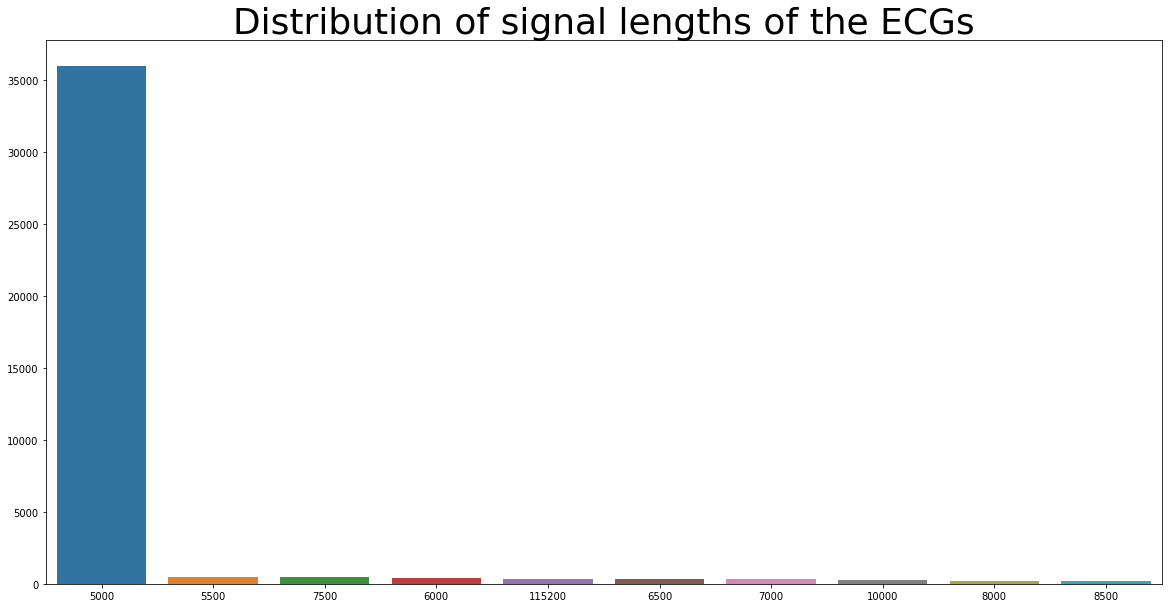

In [6]:
get_signal_lengths("./WFDB/", "Distribution of signal lengths of the ECGs")

In [7]:
def clean_up_gender_data(gender):
  gender = np.asarray(gender)
  gender[np.where(gender == "Male")] = 0
  gender[np.where(gender == "male")] = 0
  gender[np.where(gender == "M")] = 0
  gender[np.where(gender == "Female")] = 1
  gender[np.where(gender == "female")] = 1
  gender[np.where(gender == "F")] = 1
  gender[np.where(gender == "NaN")] = 2
  np.unique(gender)
  gender = gender.astype(np.int)
  return gender

def clean_up_age_data(age):
    age = np.asarray(age)
    age[np.where(age == "NaN")] = -1
    np.unique(age)
    age = age.astype(np.int)
    return age

def import_gender_and_age(age, gender):
    gender_binary = clean_up_gender_data(gender)
    age_clean = clean_up_age_data(age)
    print("gender data shape: {}".format(gender_binary.shape[0]))
    print("age data shape: {}".format(age_clean.shape[0]))
    return age_clean, gender_binary

In [8]:
age, gender = import_gender_and_age(age, gender)

gender data shape: 43101
age data shape: 43101


In [9]:
def make_undefined_class(labels, df_unscored):
    df_labels = pd.DataFrame(labels)
    for i in range(len(df_unscored.iloc[0:,1])):
        df_labels.replace(to_replace=str(df_unscored.iloc[i,1]), inplace=True ,value="undefined class", regex=True)

    return df_labels

In [10]:
SNOMED_scored=pd.read_csv("SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("SNOMED_mappings_unscored.csv", sep=";")
df_labels = make_undefined_class(labels,SNOMED_unscored)

In [11]:
def onehot_encode(df_labels):
    one_hot = MultiLabelBinarizer()
    y=one_hot.fit_transform(df_labels[0].str.split(pat=','))
    print("The classes we will look at are encoded as SNOMED CT codes:")
    print(one_hot.classes_)
    y = np.delete(y, -1, axis=1)
    print("classes: {}".format(y.shape[1]))
    return y, one_hot.classes_[0:-1]

In [12]:
y , snomed_classes = onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


In [13]:
def plot_classes(classes, scored_classes,y):
    for j in range(len(classes)):
        for i in range(len(scored_classes.iloc[:,1])):
            if (str(scored_classes.iloc[:,1][i]) == classes[j]):
                classes[j] = scored_classes.iloc[:,0][i]
    plt.figure(figsize=(30,20))
    plt.bar(x=classes,height=y.sum(axis=0))
    plt.title("Distribution of Diagnosis", color = "black", fontsize = 30)
    plt.tick_params(axis="both", colors = "black")
    plt.xlabel("Diagnosis", color = "black")
    plt.ylabel("Count", color = "black")
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize = 20)
    plt.savefig("fordeling.png")
    plt.show()

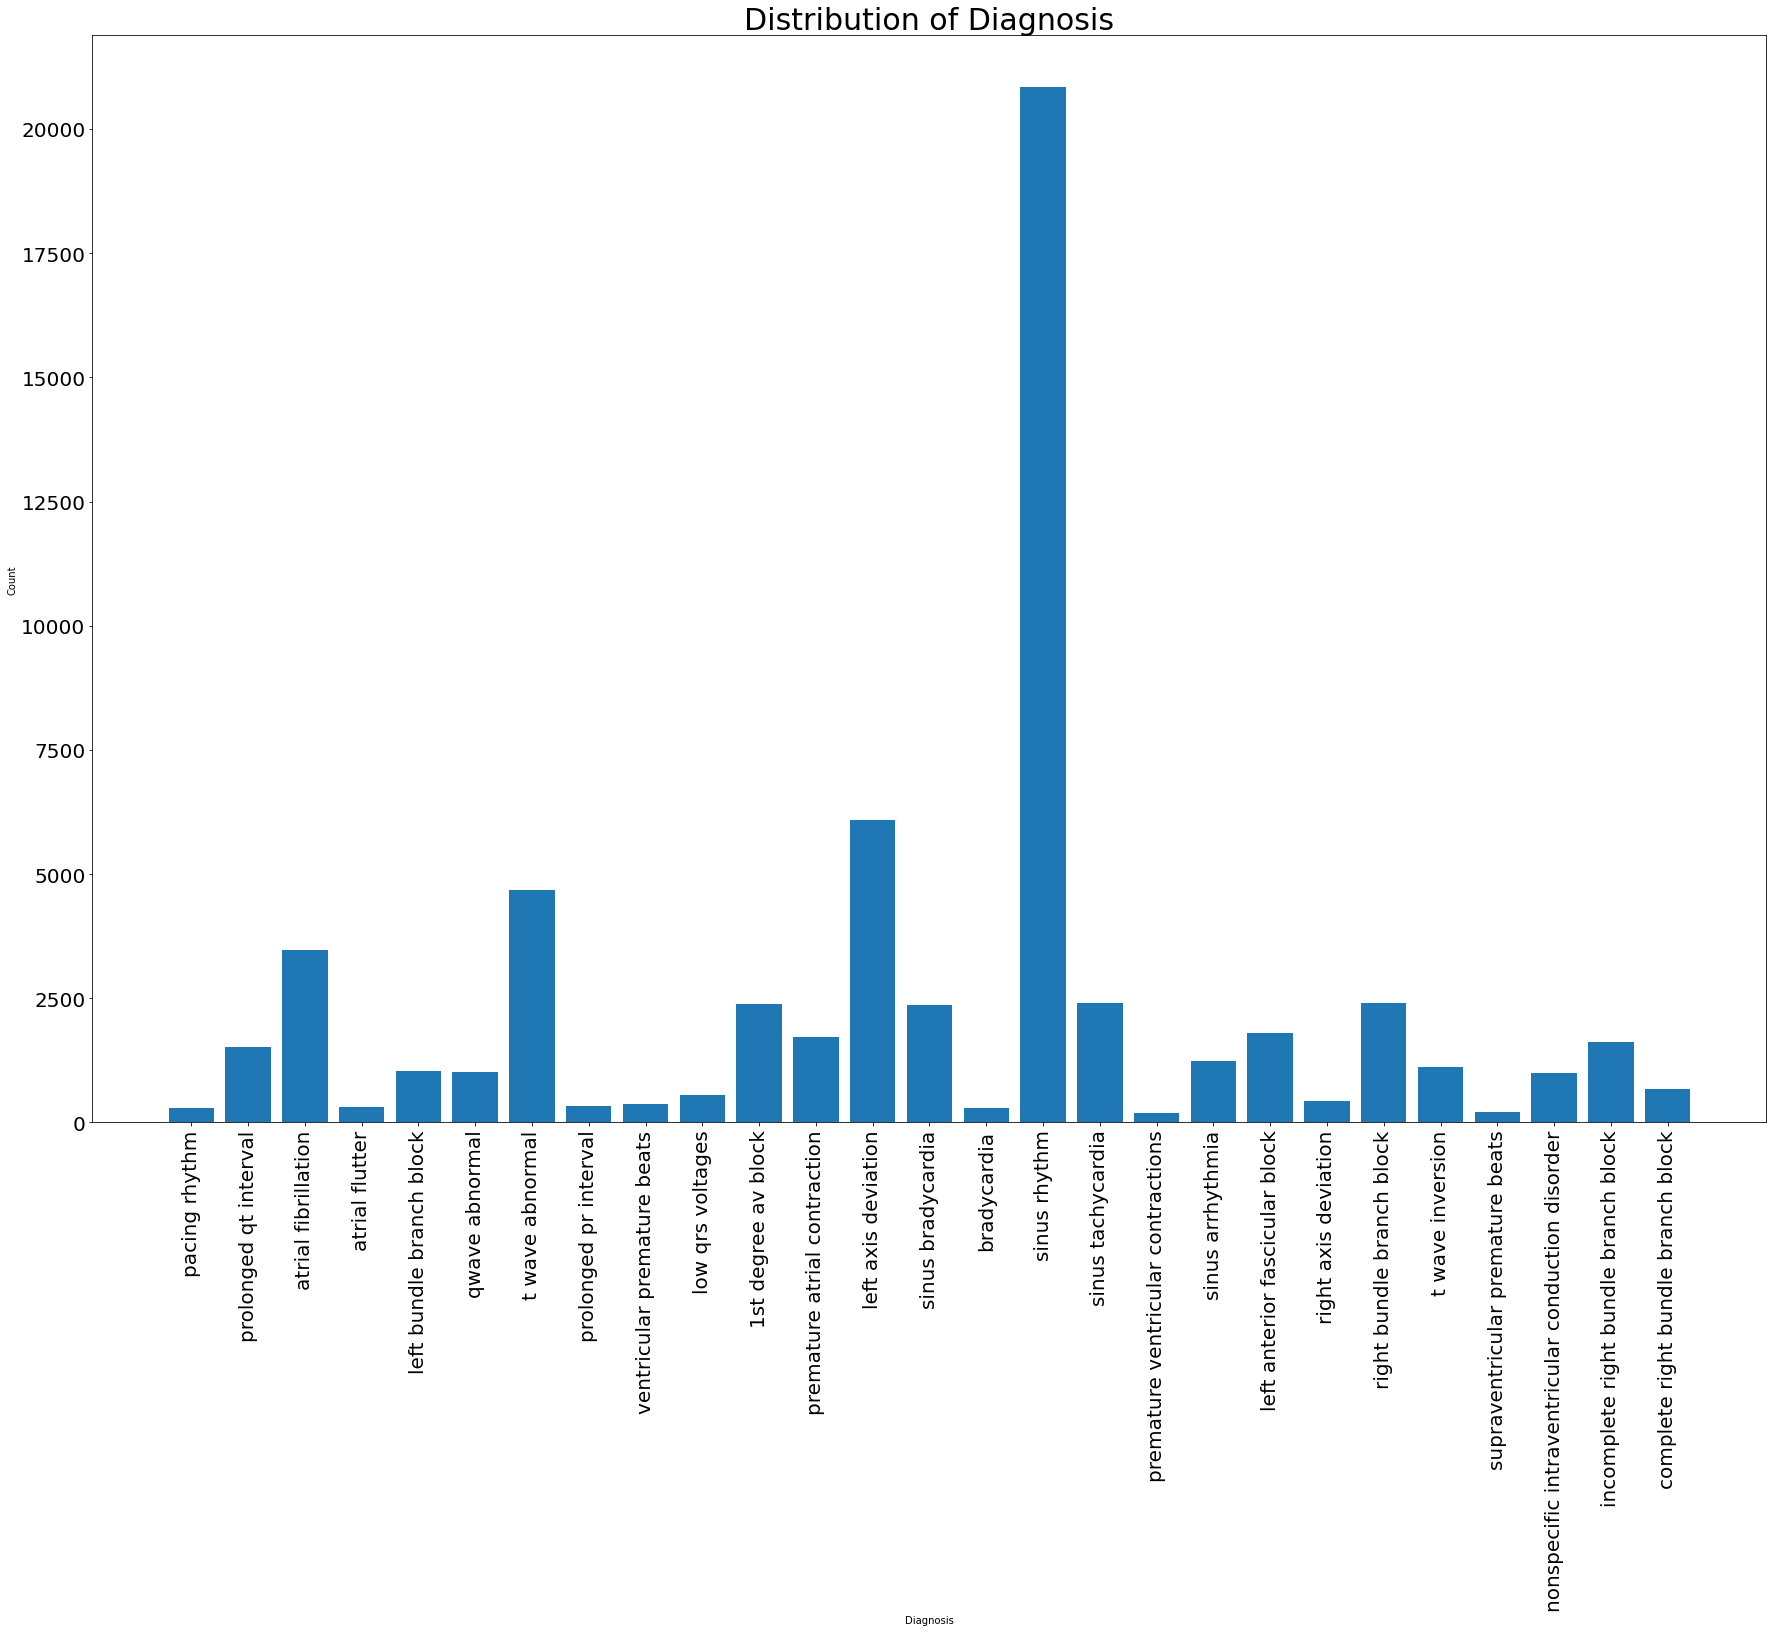

In [14]:
plot_classes(snomed_classes, SNOMED_scored,y)

In [15]:
def get_labels_for_all_combinations(y):
    y_all_combinations = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    return y_all_combinations

In [16]:
y_all_comb = get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))

Total number of unique combinations of diagnosis: 1414


In [17]:
def split_data(labels, y_all_combo):
    folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(labels,y_all_combo))
    print("Training split: {}".format(len(folds[0][0])))
    print("Validation split: {}".format(len(folds[0][1])))
    return folds

In [18]:
def split_data_opt(labels, y_all_combo):
    folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=42).split(labels,y_all_combo))
    print("Training split: {}".format(len(folds[0][0])))
    print("Validation split: {}".format(len(folds[0][1])))
    return folds

In [19]:
folds = split_data(labels, y_all_comb)

Training split: 38790
Validation split: 4311


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [20]:
def plot_all_folds(folds,y,onehot_enc):
    X_axis_labels=onehot_enc
    plt.figure(figsize=(20,100))
    h=1
    for i in range(len(folds)):
        plt.subplot(10,2,h)
        plt.subplots_adjust(hspace=1.0)
        plt.bar(x= X_axis_labels, height=y[folds[i][0]].sum(axis=0))
        plt.title("Distribution of Diagnosis - Training set - Fold {}".format(i+1) ,fontsize="20", color = "black")
        plt.tick_params(axis="both", colors = "black")
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize = 10)
        #plt.xlabel("Diagnosis", color = "white")
        plt.ylabel("Count", color = "black")
        h=h+1
        plt.subplot(10,2,h)
        plt.subplots_adjust(hspace=1.0)
        plt.bar(x= X_axis_labels, height=y[folds[i][1]].sum(axis=0))
        plt.title("Distribution of Diagnosis - Validation set - Fold {}".format(i+1) ,fontsize="20", color = "black")
        plt.tick_params(axis="both", colors = "black")
        #plt.xlabel("Diagnosis", color = "white")
        plt.ylabel("Count", color = "black")
        plt.xticks(rotation=90, fontsize=10)
        plt.yticks(fontsize = 10)
        h=h+1

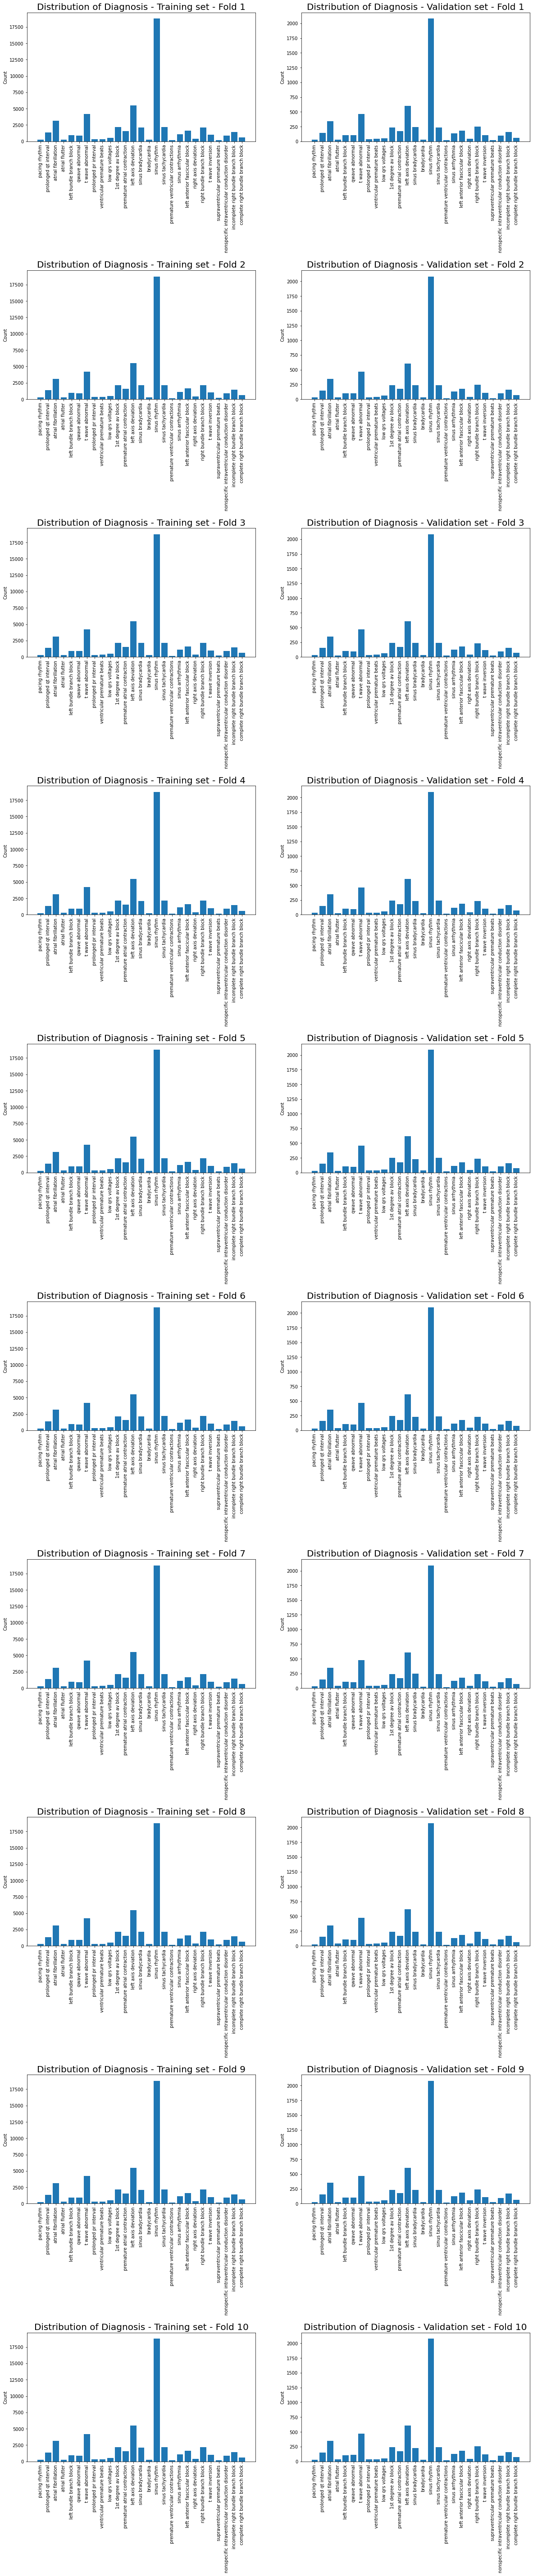

In [21]:
plot_all_folds(folds,y,snomed_classes)

In [22]:
def shuffle_batch_generator_demo(batch_size, gen_x,gen_y, gen_z): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    batch_demo_data = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            batch_demo_data[i] = next(gen_z)

        X_combined = [batch_features, batch_demo_data]
        yield X_combined, batch_labels
        
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

def generate_z_shuffle(age_train, gender_train):
    while True:
        for i in order_array:
            gen_age = age_train[i]
            gen_gender = gender_train[i]
            z_train = [gen_age , gen_gender]
            yield z_train

In [23]:
def calculating_class_weights(y_true):
    number_dim = np.shape(y_true)[1]
    weights = np.empty([number_dim, 2])
    for i in range(number_dim):
        weights[i] = compute_class_weight('balanced', [0.,1.], y_true[:, i])
    return weights

In [24]:
new_weights=calculating_class_weights(y)

In [25]:
keys = np.arange(0,27,1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary

{0: 72.0752508361204,
 1: 14.243555849306015,
 2: 6.201582733812949,
 3: 68.63216560509554,
 4: 20.701729106628243,
 5: 21.273938795656466,
 6: 4.611705542478066,
 7: 63.383823529411764,
 8: 59.04246575342466,
 9: 38.759892086330936,
 10: 9.00187969924812,
 11: 12.464141122035858,
 12: 3.5409957279000985,
 13: 9.13543874523103,
 14: 74.828125,
 15: 1.0337954523649622,
 16: 8.971898417985013,
 17: 114.63031914893617,
 18: 17.379435483870967,
 19: 11.932724252491694,
 20: 50.469555035128806,
 21: 8.971898417985013,
 22: 19.379946043165468,
 23: 100.23488372093023,
 24: 21.615346038114343,
 25: 13.37709497206704,
 26: 31.552708638360176}

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [27]:
from scipy import optimize
def thr_chall_metrics(thr, label, output_prob):
    return -compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

In [28]:
def iterate_threshold(y_pred, ecg_filenames, y ,val_fold ):
    init_thresholds = np.arange(0,1,0.05)
    
    all_scores = []
    for i in init_thresholds:
        pred_output = y_pred > i
        pred_output = pred_output * 1
        score = compute_challenge_metric_for_opt(generate_validation_data(ecg_filenames,y,val_fold)[1],pred_output)
        print(score)
        all_scores.append(score)
    all_scores = np.asarray(all_scores)
    
    return all_scores

In [29]:
def iterate_threshold_new(y_true,y_pred):
    init_thresholds = np.arange(0,1,0.05)
    
    all_scores = []
    for i in init_thresholds:
        pred_output = y_pred > i
        pred_output = pred_output * 1
        score = compute_challenge_metric_for_opt(y_true,pred_output)
        print(score)
        all_scores.append(score)
    all_scores = np.asarray(all_scores)
    
    return all_scores

In [30]:
def generate_validation_data(ecg_filenames, y,test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_train_gridsearch = np.asarray(ecg_train_timeseries)

    X_train_gridsearch = X_train_gridsearch.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)

    return X_train_gridsearch, y_train_gridsearch

In [31]:
def generate_validation_data_with_demo_data(ecg_filenames, y, gender, age, test_order_array):
    y_train_gridsearch=y[test_order_array]
    ecg_filenames_train_gridsearch=ecg_filenames[test_order_array]

    ecg_train_timeseries=[]
    for names in ecg_filenames_train_gridsearch:
        data, header_data = load_challenge_data(names)
        data = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
        ecg_train_timeseries.append(data)
    X_val = np.asarray(ecg_train_timeseries)

    X_val = X_val.reshape(ecg_filenames_train_gridsearch.shape[0],5000,12)
    
    age_val = age[test_order_array]
    
    gender_val = gender[test_order_array]
    
    demograpics_val_data = np.column_stack((age_val, gender_val))
    X_combined_val = [X_val, demograpics_val_data]

    return X_combined_val, y_train_gridsearch

In [32]:
def compute_challenge_metric_for_opt(labels, outputs):
    classes=['10370003','111975006','164889003','164890007','164909002','164917005','164934002','164947007','17338001',
 '251146004','270492004','284470004','39732003','426177001','426627000','426783006','427084000','427172004','427393009','445118002','47665007','59118001',
 '59931005','63593006','698252002','713426002','713427006']


    normal_class = '426783006'
    weights = np.array([[1.    , 0.425 , 0.375 , 0.375 , 0.4   , 0.275 , 0.375 , 0.425 ,
        0.5   , 0.45  , 0.425 , 0.4625, 0.475 , 0.425 , 0.425 , 0.375 ,
        0.5   , 0.5   , 0.425 , 0.475 , 0.475 , 0.475 , 0.375 , 0.4625,
        0.475 , 0.425 , 0.475 ],
       [0.425 , 1.    , 0.45  , 0.45  , 0.475 , 0.35  , 0.45  , 0.35  ,
        0.425 , 0.475 , 0.35  , 0.3875, 0.4   , 0.35  , 0.35  , 0.3   ,
        0.425 , 0.425 , 0.35  , 0.4   , 0.4   , 0.45  , 0.45  , 0.3875,
        0.4   , 0.35  , 0.45  ],
       [0.375 , 0.45  , 1.    , 0.5   , 0.475 , 0.4   , 0.5   , 0.3   ,
        0.375 , 0.425 , 0.3   , 0.3375, 0.35  , 0.3   , 0.3   , 0.25  ,
        0.375 , 0.375 , 0.3   , 0.35  , 0.35  , 0.4   , 0.5   , 0.3375,
        0.35  , 0.3   , 0.4   ],
       [0.375 , 0.45  , 0.5   , 1.    , 0.475 , 0.4   , 0.5   , 0.3   ,
        0.375 , 0.425 , 0.3   , 0.3375, 0.35  , 0.3   , 0.3   , 0.25  ,
        0.375 , 0.375 , 0.3   , 0.35  , 0.35  , 0.4   , 0.5   , 0.3375,
        0.35  , 0.3   , 0.4   ],
       [0.4   , 0.475 , 0.475 , 0.475 , 1.    , 0.375 , 0.475 , 0.325 ,
        0.4   , 0.45  , 0.325 , 0.3625, 0.375 , 0.325 , 0.325 , 0.275 ,
        0.4   , 0.4   , 0.325 , 0.375 , 0.375 , 0.425 , 0.475 , 0.3625,
        0.375 , 0.325 , 0.425 ],
       [0.275 , 0.35  , 0.4   , 0.4   , 0.375 , 1.    , 0.4   , 0.2   ,
        0.275 , 0.325 , 0.2   , 0.2375, 0.25  , 0.2   , 0.2   , 0.15  ,
        0.275 , 0.275 , 0.2   , 0.25  , 0.25  , 0.3   , 0.4   , 0.2375,
        0.25  , 0.2   , 0.3   ],
       [0.375 , 0.45  , 0.5   , 0.5   , 0.475 , 0.4   , 1.    , 0.3   ,
        0.375 , 0.425 , 0.3   , 0.3375, 0.35  , 0.3   , 0.3   , 0.25  ,
        0.375 , 0.375 , 0.3   , 0.35  , 0.35  , 0.4   , 0.5   , 0.3375,
        0.35  , 0.3   , 0.4   ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 1.    ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 0.5   , 0.5   , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.5   , 0.425 , 0.375 , 0.375 , 0.4   , 0.275 , 0.375 , 0.425 ,
        1.    , 0.45  , 0.425 , 0.4625, 0.475 , 0.425 , 0.425 , 0.375 ,
        0.5   , 1.    , 0.425 , 0.475 , 0.475 , 0.475 , 0.375 , 0.4625,
        0.475 , 0.425 , 0.475 ],
       [0.45  , 0.475 , 0.425 , 0.425 , 0.45  , 0.325 , 0.425 , 0.375 ,
        0.45  , 1.    , 0.375 , 0.4125, 0.425 , 0.375 , 0.375 , 0.325 ,
        0.45  , 0.45  , 0.375 , 0.425 , 0.425 , 0.475 , 0.425 , 0.4125,
        0.425 , 0.375 , 0.475 ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 1.    , 0.4625, 0.45  , 0.5   , 0.5   , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.4625, 0.3875, 0.3375, 0.3375, 0.3625, 0.2375, 0.3375, 0.4625,
        0.4625, 0.4125, 0.4625, 1.    , 0.4875, 0.4625, 0.4625, 0.4125,
        0.4625, 0.4625, 0.4625, 0.4875, 0.4875, 0.4375, 0.3375, 1.    ,
        0.4875, 0.4625, 0.4375],
       [0.475 , 0.4   , 0.35  , 0.35  , 0.375 , 0.25  , 0.35  , 0.45  ,
        0.475 , 0.425 , 0.45  , 0.4875, 1.    , 0.45  , 0.45  , 0.4   ,
        0.475 , 0.475 , 0.45  , 0.5   , 0.5   , 0.45  , 0.35  , 0.4875,
        0.5   , 0.45  , 0.45  ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 1.    , 0.5   , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 0.5   , 1.    , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.375 , 0.3   , 0.25  , 0.25  , 0.275 , 0.15  , 0.25  , 0.45  ,
        0.375 , 0.325 , 0.45  , 0.4125, 0.4   , 0.45  , 0.45  , 1.    ,
        0.375 , 0.375 , 0.45  , 0.4   , 0.4   , 0.35  , 0.25  , 0.4125,
        0.4   , 0.45  , 0.35  ],
       [0.5   , 0.425 , 0.375 , 0.375 , 0.4   , 0.275 , 0.375 , 0.425 ,
        0.5   , 0.45  , 0.425 , 0.4625, 0.475 , 0.425 , 0.425 , 0.375 ,
        1.    , 0.5   , 0.425 , 0.475 , 0.475 , 0.475 , 0.375 , 0.4625,
        0.475 , 0.425 , 0.475 ],
       [0.5   , 0.425 , 0.375 , 0.375 , 0.4   , 0.275 , 0.375 , 0.425 ,
        1.    , 0.45  , 0.425 , 0.4625, 0.475 , 0.425 , 0.425 , 0.375 ,
        0.5   , 1.    , 0.425 , 0.475 , 0.475 , 0.475 , 0.375 , 0.4625,
        0.475 , 0.425 , 0.475 ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 0.5   , 0.5   , 0.45  ,
        0.425 , 0.425 , 1.    , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 0.5   , 0.4   ],
       [0.475 , 0.4   , 0.35  , 0.35  , 0.375 , 0.25  , 0.35  , 0.45  ,
        0.475 , 0.425 , 0.45  , 0.4875, 0.5   , 0.45  , 0.45  , 0.4   ,
        0.475 , 0.475 , 0.45  , 1.    , 0.5   , 0.45  , 0.35  , 0.4875,
        0.5   , 0.45  , 0.45  ],
       [0.475 , 0.4   , 0.35  , 0.35  , 0.375 , 0.25  , 0.35  , 0.45  ,
        0.475 , 0.425 , 0.45  , 0.4875, 0.5   , 0.45  , 0.45  , 0.4   ,
        0.475 , 0.475 , 0.45  , 0.5   , 1.    , 0.45  , 0.35  , 0.4875,
        0.5   , 0.45  , 0.45  ],
       [0.475 , 0.45  , 0.4   , 0.4   , 0.425 , 0.3   , 0.4   , 0.4   ,
        0.475 , 0.475 , 0.4   , 0.4375, 0.45  , 0.4   , 0.4   , 0.35  ,
        0.475 , 0.475 , 0.4   , 0.45  , 0.45  , 1.    , 0.4   , 0.4375,
        0.45  , 0.4   , 1.    ],
       [0.375 , 0.45  , 0.5   , 0.5   , 0.475 , 0.4   , 0.5   , 0.3   ,
        0.375 , 0.425 , 0.3   , 0.3375, 0.35  , 0.3   , 0.3   , 0.25  ,
        0.375 , 0.375 , 0.3   , 0.35  , 0.35  , 0.4   , 1.    , 0.3375,
        0.35  , 0.3   , 0.4   ],
       [0.4625, 0.3875, 0.3375, 0.3375, 0.3625, 0.2375, 0.3375, 0.4625,
        0.4625, 0.4125, 0.4625, 1.    , 0.4875, 0.4625, 0.4625, 0.4125,
        0.4625, 0.4625, 0.4625, 0.4875, 0.4875, 0.4375, 0.3375, 1.    ,
        0.4875, 0.4625, 0.4375],
       [0.475 , 0.4   , 0.35  , 0.35  , 0.375 , 0.25  , 0.35  , 0.45  ,
        0.475 , 0.425 , 0.45  , 0.4875, 0.5   , 0.45  , 0.45  , 0.4   ,
        0.475 , 0.475 , 0.45  , 0.5   , 0.5   , 0.45  , 0.35  , 0.4875,
        1.    , 0.45  , 0.45  ],
       [0.425 , 0.35  , 0.3   , 0.3   , 0.325 , 0.2   , 0.3   , 0.5   ,
        0.425 , 0.375 , 0.5   , 0.4625, 0.45  , 0.5   , 0.5   , 0.45  ,
        0.425 , 0.425 , 0.5   , 0.45  , 0.45  , 0.4   , 0.3   , 0.4625,
        0.45  , 1.    , 0.4   ],
       [0.475 , 0.45  , 0.4   , 0.4   , 0.425 , 0.3   , 0.4   , 0.4   ,
        0.475 , 0.475 , 0.4   , 0.4375, 0.45  , 0.4   , 0.4   , 0.35  ,
        0.475 , 0.475 , 0.4   , 0.45  , 0.45  , 1.    , 0.4   , 0.4375,
        0.45  , 0.4   , 1.    ]])
    
    num_recordings, num_classes = np.shape(labels)
    normal_index = classes.index(normal_class)

    # Compute the observed score.
    A = compute_modified_confusion_matrix(labels, outputs)
    observed_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the correct label(s).
    correct_outputs = labels
    A = compute_modified_confusion_matrix(labels, correct_outputs)
    correct_score = np.nansum(weights * A)

    # Compute the score for the model that always chooses the normal class.
    inactive_outputs = np.zeros((num_recordings, num_classes), dtype=np.bool)
    inactive_outputs[:, normal_index] = 1
    A = compute_modified_confusion_matrix(labels, inactive_outputs)
    inactive_score = np.nansum(weights * A)

    if correct_score != inactive_score:
        normalized_score = float(observed_score - inactive_score) / float(correct_score - inactive_score)
    else:
        normalized_score = float('nan')

    return normalized_score

def compute_modified_confusion_matrix(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0/normalization

    return A


def compute_f_measure(labels, outputs):
    num_recordings, num_classes = np.shape(labels)

    A = compute_confusion_matrices(labels, outputs)

    f_measure = np.zeros(num_classes)
    for k in range(num_classes):
        tp, fp, fn, tn = A[k, 1, 1], A[k, 1, 0], A[k, 0, 1], A[k, 0, 0]
        if 2 * tp + fp + fn:
            f_measure[k] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            f_measure[k] = float('nan')

    macro_f_measure = np.nanmean(f_measure)

    return macro_f_measure

# Compute F-beta and G-beta measures from the unofficial phase of the Challenge.
def compute_beta_measures(labels, outputs, beta):
    num_recordings, num_classes = np.shape(labels)

    A = compute_confusion_matrices(labels, outputs, normalize=True)

    f_beta_measure = np.zeros(num_classes)
    g_beta_measure = np.zeros(num_classes)
    for k in range(num_classes):
        tp, fp, fn, tn = A[k, 1, 1], A[k, 1, 0], A[k, 0, 1], A[k, 0, 0]
        if (1+beta**2)*tp + fp + beta**2*fn:
            f_beta_measure[k] = float((1+beta**2)*tp) / float((1+beta**2)*tp + fp + beta**2*fn)
        else:
            f_beta_measure[k] = float('nan')
        if tp + fp + beta*fn:
            g_beta_measure[k] = float(tp) / float(tp + fp + beta*fn)
        else:
            g_beta_measure[k] = float('nan')

    macro_f_beta_measure = np.nanmean(f_beta_measure)
    macro_g_beta_measure = np.nanmean(g_beta_measure)

    return macro_f_beta_measure, macro_g_beta_measure

# Compute recording-wise accuracy.
def compute_accuracy(labels, outputs):
    num_recordings, num_classes = np.shape(labels)

    num_correct_recordings = 0
    for i in range(num_recordings):
        if np.all(labels[i, :]==outputs[i, :]):
            num_correct_recordings += 1

    return float(num_correct_recordings) / float(num_recordings)

# Compute confusion matrices.
def compute_confusion_matrices(labels, outputs, normalize=False):
    # Compute a binary confusion matrix for each class k:
    #
    #     [TN_k FN_k]
    #     [FP_k TP_k]
    #
    # If the normalize variable is set to true, then normalize the contributions
    # to the confusion matrix by the number of labels per recording.
    num_recordings, num_classes = np.shape(labels)

    if not normalize:
        A = np.zeros((num_classes, 2, 2))
        for i in range(num_recordings):
            for j in range(num_classes):
                if labels[i, j]==1 and outputs[i, j]==1: # TP
                    A[j, 1, 1] += 1
                elif labels[i, j]==0 and outputs[i, j]==1: # FP
                    A[j, 1, 0] += 1
                elif labels[i, j]==1 and outputs[i, j]==0: # FN
                    A[j, 0, 1] += 1
                elif labels[i, j]==0 and outputs[i, j]==0: # TN
                    A[j, 0, 0] += 1
                else: # This condition should not happen.
                    raise ValueError('Error in computing the confusion matrix.')
    else:
        A = np.zeros((num_classes, 2, 2))
        for i in range(num_recordings):
            normalization = float(max(np.sum(labels[i, :]), 1))
            for j in range(num_classes):
                if labels[i, j]==1 and outputs[i, j]==1: # TP
                    A[j, 1, 1] += 1.0/normalization
                elif labels[i, j]==0 and outputs[i, j]==1: # FP
                    A[j, 1, 0] += 1.0/normalization
                elif labels[i, j]==1 and outputs[i, j]==0: # FN
                    A[j, 0, 1] += 1.0/normalization
                elif labels[i, j]==0 and outputs[i, j]==0: # TN
                    A[j, 0, 0] += 1.0/normalization
                else: # This condition should not happen.
                    raise ValueError('Error in computing the confusion matrix.')

    return A


def compute_modified_confusion_matrix_nonorm(labels, outputs):
    # Compute a binary multi-class, multi-label confusion matrix, where the rows
    # are the labels and the columns are the outputs.
    num_recordings, num_classes = np.shape(labels)
    A = np.zeros((num_classes, num_classes))

    # Iterate over all of the recordings.
    for i in range(num_recordings):
        # Calculate the number of positive labels and/or outputs.
        #####normalization = float(max(np.sum(np.any((labels[i, :], outputs[i, :]), axis=0)), 1))
        # Iterate over all of the classes.
        for j in range(num_classes):
            # Assign full and/or partial credit for each positive class.
            if labels[i, j]:
                for k in range(num_classes):
                    if outputs[i, k]:
                        A[j, k] += 1.0#/normalization

    return A


def plot_classes(classes,snomedscored,y_label):
    for j in range(len(classes)):
        for i in range(len(snomedscored.iloc[:,1])):
            if (str(snomedscored.iloc[:,1][i]) == classes[j]):
                classes[j] = snomedscored.iloc[:,0][i]
    plt.style.use(['seaborn-paper'])      
    plt.figure(figsize=(30,20))
    plt.bar(x=classes,height=y_label.sum(axis=0),color="black")
    #plt.title("Distribution of Diagnosis", color = "black")
    plt.tick_params(axis="both", colors = "black")
    plt.xlabel("Diagnosis", color = "black",fontsize = 40)
    plt.ylabel("Count", color = "black", fontsize=40)
    plt.xticks(rotation=90, fontsize=40)
    plt.yticks(fontsize = 40)
    plt.savefig("diagnoses_distribution.png",dpi=200,bbox_inches = 'tight')
    plt.show()
    

def plot_classes_2(classes,y_label,snomedscored, norskliste):

    for j in range(len(classes)):
        for i in range(len(snomedscored.iloc[:,1])):
            if (str(snomedscored.iloc[:,1][i]) == classes[j]):
                classes[j] = snomedscored.iloc[:,0][i]
    plt.figure(figsize=(20,10))
    plt.gca()
    plt.bar(x=norskliste,height=y_label.sum(axis=0))
    #plt.title("Distribution of Diagnosis", color = "black")
    plt.tick_params(axis="both", colors = "black")
    plt.xlabel("Diagnoser", color = "black", fontsize=20)
    plt.ylabel("Antall", color = "black", fontsize=20)

    plt.xticks(rotation=90, fontsize=20)
    #plt.grid()
    plt.yticks(fontsize = 20)
    plt.savefig("fordeling.png",dpi=200,bbox_inches = 'tight')
    plt.show()

In [33]:
def DetectRWithPanTompkins (signal, signal_freq):
    '''signal=ECG signal (type=np.array), signal_freq=sample frequenzy'''
    lowcut = 5.0
    highcut = 15.0
    filter_order = 2
    
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    
    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, signal)
    
    diff_y=np.ediff1d(y)
    squared_diff_y=diff_y**2
    
    integrated_squared_diff_y =np.convolve(squared_diff_y,np.ones(5))
    
    normalized = (integrated_squared_diff_y-min(integrated_squared_diff_y))/(max(integrated_squared_diff_y)-min(integrated_squared_diff_y))

    peaks, metadata = find_peaks(normalized, 
                             distance=signal_freq/5 , 
                             #height=500,
                             height=0.5,
                             width=0.5
                            )

    return peaks

def heartrate(r_time, sampfreq):
    
    #qrs = xqrs.qrs_inds from annotateR()
    #sampfreq = sample frequency - can be found with y['fs'] (from getDataFromPhysionet())
    
    HeartRate = []
    TimeBetweenBeat= []
    for index, item in enumerate(r_time,-1):
        HeartRate.append(60/((r_time[index+1]-r_time[index])/sampfreq))
        TimeBetweenBeat.append((r_time[index+1]-r_time[index])/sampfreq)
    del HeartRate[0]
    avgHr = sum(HeartRate)/len(HeartRate)
    TimeBetweenBeat= np.asarray(TimeBetweenBeat)
    TimeBetweenBeat=TimeBetweenBeat * 1000 # sec to ms
    TimeBetweenBeat = TimeBetweenBeat[1:] # remove first element
    return TimeBetweenBeat, avgHr

def R_correction(signal, peaks):
    '''signal = ECG signal, peaks = uncorrected R peaks'''
    peaks_corrected, metadata = find_peaks(signal, distance=min(np.diff(peaks)))            
    return peaks_corrected

def rule_based_predictions(ecgfilenames, val_data, dnn_prediction):
    for i in range(len(val_data)):
        data , header_data = load_challenge_data(ecgfilenames[val_data[i]])

        avg_hr = 0
        peaks = 0
        rmssd = 0
        qrs_voltage = 0
        try:
            peaks = DetectRWithPanTompkins(data[1],int(header_data[0].split()[2]))

            try:
                peaks = R_correction(data[1], peaks)
            except:
                #print("Did not manage to do R_correction")

        except:
            #print("Did not manage to find any peaks using Pan Tomkins")


        try:
            rr_interval, avg_hr = heartrate(peaks,int(header_data[0].split()[2]))
            try:
                rmssd = np.mean(np.square(np.diff(rr_interval)))
            except:
                #print("did not manage to comp rmssd")
        except:
            #print("not able to calculate heart rate")
            rr_interval = 0
            avg_hr = 0

        try:
            qrs_voltage = np.mean(data[1][peaks])
        except:
            #print("Could not calculate mean QRS peak voltage")

        if avg_hr != 0:     # bare gjør disse endringene dersom vi klarer å beregne puls
            if 60 < avg_hr < 100:
                dnn_prediction[i][16] = 0
                dnn_prediction[i][14] = 0
                dnn_prediction[i][13] = 0
            elif avg_hr < 60 & dnn_prediction[i][15] == 1:
                dnn_prediction[i][13] = 1
            elif avg_hr < 60 & dnn_prediction[i][15] == 0:
                dnn_prediction[i][14] = 1
            elif avg_hr > 100:
                dnn_prediction[i][16] = 1

        if qrs_voltage != 0:
            if qrs_voltage < 500:
                dnn_prediction[i][9] = 1
                dnn_prediction[i][15] = 0
            else:
                dnn_prediction[i][9] = 0
        else:
            dnn_prediction[i][9] = 0

        if rmssd != 0:
            if rmssd < 15:
                dnn_prediction[i][0] = 1
                dnn_prediction[i][16] = 0
                dnn_prediction[i][15] = 0
                dnn_prediction[i][14] = 0
                dnn_prediction[i][13] = 0
            elif 2000 < rmssd < 5000:
                dnn_prediction[i][18] = 1
            elif 15000 < rmssd < 50000:
                dnn_prediction[i][2] = 1
            else:
                dnn_prediction[i][15] = 1
    return dnn_prediction

In [34]:
def FCN_Encoder():

    inputA = tf.keras.layers.Input(shape=(5000,12))

  
    conv1 = keras.layers.Conv1D(filters=128, kernel_size=8,input_shape=(5000,12), padding='same')(inputA)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)

    conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.Activation('relu')(conv2)

    conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.Activation('relu')(conv3)

    gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)
    model1 = keras.Model(inputs=inputA, outputs=gap_layer)

    conv1 = keras.layers.Conv1D(filters=128,kernel_size=5,strides=1,padding='same')(inputA)
    conv1 = tfa.layers.InstanceNormalization()(conv1)
    conv1 = keras.layers.PReLU(shared_axes=[1])(conv1)
    conv1 = keras.layers.Dropout(rate=0.2)(conv1)
    conv1 = keras.layers.MaxPooling1D(pool_size=2)(conv1)
    # conv block -2
    conv2 = keras.layers.Conv1D(filters=256,kernel_size=11,strides=1,padding='same')(conv1)
    conv2 = tfa.layers.InstanceNormalization()(conv2)
    conv2 = keras.layers.PReLU(shared_axes=[1])(conv2)
    conv2 = keras.layers.Dropout(rate=0.2)(conv2)
    conv2 = keras.layers.MaxPooling1D(pool_size=2)(conv2)
    # conv block -3
    conv3 = keras.layers.Conv1D(filters=512,kernel_size=21,strides=1,padding='same')(conv2)
    conv3 = tfa.layers.InstanceNormalization()(conv3)
    conv3 = keras.layers.PReLU(shared_axes=[1])(conv3)
    conv3 = keras.layers.Dropout(rate=0.2)(conv3)
    # split for attention
    attention_data = keras.layers.Lambda(lambda x: x[:,:,:256])(conv3)
    attention_softmax = keras.layers.Lambda(lambda x: x[:,:,256:])(conv3)
    # attention mechanism
    attention_softmax = keras.layers.Softmax()(attention_softmax)
    multiply_layer = keras.layers.Multiply()([attention_softmax,attention_data])
    # last layer
    dense_layer = keras.layers.Dense(units=256,activation='sigmoid')(multiply_layer)
    dense_layer = tfa.layers.InstanceNormalization()(dense_layer)
    # output layer
    flatten_layer = keras.layers.Flatten()(dense_layer)
    model2 = keras.Model(inputs=inputA, outputs=flatten_layer)

    combined = keras.layers.concatenate([model1.output, model2.output])
    final_layer = keras.layers.Dense(27, activation="sigmoid")(combined)
    model = keras.models.Model(inputs=inputA, outputs=final_layer)



    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])


    return model

In [35]:
val_res_rule = np.zeros(shape=(6,10))
training_res_rule = np.zeros(shape=(6,10))

val_res = np.zeros(shape=(6,10))
training_res = np.zeros(shape=(6,10))

score_array=[]
for i in range(len(folds)):
    print("{}-fold".format(i))
    y_train = y[folds[i][0]]
    y_val = y[folds[i][1]]
    order_array = folds[i][0]
    model = FCN_Encoder() # velg modell
    batchsize = 30
    model.fit(x=shuffle_batch_generator_demo(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), gen_y=generate_y_shuffle(y), gen_z=generate_z_shuffle(age, gender)), epochs=100, steps_per_epoch=(len(order_array)/batchsize), validation_data=generate_validation_data_with_demo_data(ecg_filenames,y, gender, age, folds[i][1]), verbose = 1, validation_freq=1, class_weight=weight_dictionary, callbacks=[reduce_lr,early_stop])
    print("predictioin on train data")
    y_train = y[folds[i][0]]
    y_val = y[folds[i][1]]
    y_pred_train = model.predict(x=generate_validation_data_with_demo_data(ecg_filenames,y, gender, age,folds[i][0])[0])#velg mellom demo-data eller ikke
    if i == 0:
      print("first threshold opt.")
      init_thresholds = np.arange(0,1,0.05)
      opt_fold = split_data_opt(np.asarray(labels)[folds[i][0]],y_all_comb[folds[i][0]])
      #all_scores = iterate_threshold(y_pred_train, ecg_filenames, y ,folds[i][0])
      all_scores = iterate_threshold_new(y_train[opt_fold[0][1]],y_pred_train[opt_fold[0][1]])
      #all_scores = iterate_threshold(y_pred_train, ecg_filenames, y ,folds[i][0])
      print("second threshold opt.")
      new_best_thr = optimize.fmin(thr_chall_metrics, args=(y_train[opt_fold[0][1]],y_pred_train[opt_fold[0][1]]), x0=init_thresholds[all_scores.argmax()]*np.ones(27))
    else:
      print("Optimize threshold")
      opt_fold = split_data_opt(np.asarray(labels)[folds[i][0]],y_all_comb[folds[i][0]])
      new_best_thr = optimize.fmin(thr_chall_metrics, args=(y_train[opt_fold[0][1]],y_pred_train[opt_fold[0][1]]), x0=new_best_thr)
    binary_y_pred_train =  (y_pred_train>new_best_thr)*1
    print("predictioin on test data")
    y_pred_val = model.predict(x=generate_validation_data_with_demo_data(ecg_filenames,y, gender, age,folds[i][1])[0]) #velg mellom demo-data eller ikke
    binary_y_pred_val = (y_pred_val>new_best_thr)*1

    print("Rule-based prediction")
    rb_pred_train = rule_based_predictions(ecg_filenames,folds[i][0],binary_y_pred_train)
    rb_pred_val = rule_based_predictions(ecg_filenames,folds[i][1],binary_y_pred_val)

    
    val_res[0,i] = compute_beta_measures(y_val,binary_y_pred_val,2)[0]
    val_res[1,i] = compute_beta_measures(y_val,binary_y_pred_val,2)[1]
    val_res[2,i] = compute_f_measure(y_val,binary_y_pred_val)
    val_res[3,i] = compute_accuracy(y_val,binary_y_pred_val)
    val_res[4,i] = compute_challenge_metric_for_opt(y_val,binary_y_pred_val)
    val_res[5,i] = roc_auc_score(y_val, y_pred_val)
    training_res[0,i] = compute_beta_measures(y_train,binary_y_pred_train,2)[0]
    training_res[1,i] = compute_beta_measures(y_train,binary_y_pred_train,2)[1]
    training_res[2,i] = compute_f_measure(y_train,binary_y_pred_train)
    training_res[3,i] = compute_accuracy(y_train,binary_y_pred_train)
    training_res[4,i] = compute_challenge_metric_for_opt(y_train,binary_y_pred_train)
    training_res[5,i] = roc_auc_score(y_train, y_pred_train)

    val_res_rule[0,i] = compute_beta_measures(y_val,rb_pred_val,2)[0]
    val_res_rule[1,i] = compute_beta_measures(y_val,rb_pred_val,2)[1]
    val_res_rule[2,i] = compute_f_measure(y_val,rb_pred_val)
    val_res_rule[3,i] = compute_accuracy(y_val,rb_pred_val)
    val_res_rule[4,i] = compute_challenge_metric_for_opt(y_val,rb_pred_val)
    val_res_rule[5,i] = roc_auc_score(y_val, y_pred_val)
    training_res_rule[0,i] = compute_beta_measures(y_train,rb_pred_train,2)[0]
    training_res_rule[1,i] = compute_beta_measures(y_train,rb_pred_train,2)[1]
    training_res_rule[2,i] = compute_f_measure(y_train,rb_pred_train)
    training_res_rule[3,i] = compute_accuracy(y_train,rb_pred_train)
    training_res_rule[4,i] = compute_challenge_metric_for_opt(y_train,rb_pred_train)
    training_res_rule[5,i] = roc_auc_score(y_train, y_pred_train)



    print("{}-fold cross val:".format(i))
    print("F2-score:",compute_beta_measures(y_val,binary_y_pred_val,2)[0])
    print("G2-score:",compute_beta_measures(y_val,binary_y_pred_val,2)[1])
    print("F-measure:",compute_f_measure(y_val,binary_y_pred_val))
    print("Accuracy:",compute_accuracy(y_val,binary_y_pred_val))
    print("Challenge prediction:", compute_challenge_metric_for_opt(y_val,binary_y_pred_val))
    print("Challenge prediction (train data):", compute_challenge_metric_for_opt(y_train,binary_y_pred_train))
    
validerings_resultat = pd.DataFrame(val_res)
trenings_resultat = pd.DataFrame(training_res)
validerings_resultat.to_csv("/content/drive/MyDrive/logs/valideringsresultat_FCN_Encoder.csv")
trenings_resultat.to_csv("/content/drive/MyDrive/logs/treningsresultat_FCN_Encoder.csv")

validerings_resultat_rule = pd.DataFrame(val_res_rule)
trenings_resultat_rule = pd.DataFrame(training_res_rule)
validerings_resultat_rule.to_csv("/content/drive/MyDrive/logs/valideringsresultat_FCN_Encoder_rule.csv")
trenings_resultat_rule.to_csv("/content/drive/MyDrive/logs/treningsresultat_FCN_Encoder_rule.csv")

0-fold
Epoch 1/100
1293/1293 [==============================] - 146s 113ms/step - loss: 1.7719 - accuracy: 0.9509 - Recall: 0.1277 - Precision: 0.6359 - AUC: 0.7659 - val_loss: 0.1346 - val_accuracy: 0.9547 - val_Recall: 0.1944 - val_Precision: 0.7345 - val_AUC: 0.8300
Epoch 2/100
1293/1293 [==============================] - 145s 112ms/step - loss: 1.3325 - accuracy: 0.9561 - Recall: 0.2654 - Precision: 0.7041 - AUC: 0.8583 - val_loss: 0.1299 - val_accuracy: 0.9568 - val_Recall: 0.2950 - val_Precision: 0.6924 - val_AUC: 0.8432
Epoch 3/100
1293/1293 [==============================] - ETA: 0s - loss: 0.9722 - accuracy: 0.9607 - Recall: 0.3921 - Precision: 0.7252 - AUC: 0.9010
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1293/1293 [==============================] - 145s 112ms/step - loss: 0.9722 - accuracy: 0.9607 - Recall: 0.3921 - Precision: 0.7252 - AUC: 0.9010 - val_loss: 0.1399 - val_accuracy: 0.9569 - val_Recall: 0.3108 - val_Precision: 0.6846 - v

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.15280581094005563
0.4575364120031335
0.4655062758354442
0.43506802042042675
0.40066709750955126
0.3603322131715675
0.316292659098669
0.27480304396901484
0.23330856888304108
0.18779117447572227
0.13678554514049326
0.08278733307447653
0.026237372507011716
-0.028213048154198294
-0.08419815512826706
-0.14685682228098118
-0.2117294709709409
-0.2912835306853662
-0.4026314504925451
-0.5469822737811015
second threshold opt.
Optimization terminated successfully.
         Current function value: -0.527762
         Iterations: 333
         Function evaluations: 599
predictioin on test data
Rule-based prediction


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimization terminated successfully.
         Current function value: -0.544789
         Iterations: 204
         Function evaluations: 454
predictioin on test data
Rule-based prediction
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimization terminated successfully.
         Current function value: -0.545200
         Iterations: 214
         Function evaluations: 456
predictioin on test data
Rule-based prediction
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimization terminated successfully.
         Current function value: -0.588571
         Iterations: 55
         Function evaluations: 275
predictioin on test data
Rule-based prediction
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimization terminated successfully.
         Current function value: -0.526585
         Iterations: 177
         Function evaluations: 400
predictioin on test data
Rule-based prediction
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimization terminated successfully.
         Current function value: -0.548803
         Iterations: 148
         Function evaluations: 361
predictioin on test data
Rule-based prediction
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimization terminated successfully.
         Current function value: -0.531057
         Iterations: 123
         Function evaluations: 366
predictioin on test data
Rule-based prediction
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correc

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimization terminated successfully.
         Current function value: -0.595214
         Iterations: 170
         Function evaluations: 418
predictioin on test data
Rule-based prediction


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Did not manage to do R_correction
not able to calculate heart rate
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correc

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimization terminated successfully.
         Current function value: -0.547287
         Iterations: 152
         Function evaluations: 394
predictioin on test data
Rule-based prediction
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimization terminated successfully.
         Current function value: -0.550498
         Iterations: 140
         Function evaluations: 358
predictioin on test data
Rule-based prediction
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart rate
Did not manage to do R_correction
not able to calculate heart 